In [ ]:
#Data Collection
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import shap

# Load the dataset
data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first few rows of the dataset
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#Feature Engineering
# Check for missing values
data.isnull().sum()

# Convert 'TotalCharges' to numeric, handling errors
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with median
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

# Fill missing values in categorical columns with the mode
data['PaymentMethod'] = data['PaymentMethod'].fillna(data['PaymentMethod'].mode()[0])

# One-Hot Encoding for categorical columns
data = pd.get_dummies(data, columns=[col for col in data.columns if col != 'Churn' and data[col].dtype == 'object'], drop_first=True)

# Label Encoding for the target column 'Churn' (Yes/No to 1/0)
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# Scale numerical features like 'MonthlyCharges', 'TotalCharges', 'tenure'
scaler = StandardScaler()
data[['MonthlyCharges', 'TotalCharges', 'tenure']] = scaler.fit_transform(data[['MonthlyCharges', 'TotalCharges', 'tenure']])

# Creating a new feature for tenure in years
data['tenure_years'] = data['tenure'] / 12

In [ ]:
#Model Building

# Define features (X) and target (y)
#Drop 'Churn' before one-hot encoding to keep 'customerID'
x= data.drop(['Churn'], axis=1)  #Drop Target Column

y = data['Churn']  # Target column

# Train-test split (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)

# Predict on the test set
y_pred_log_reg = log_reg.predict(x_test)

# Evaluate the model using classification metrics
print(classification_report(y_test, y_pred_log_reg))

# Initialize and train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred_rf))

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
xgb_model.fit(x_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(x_test)

# Evaluate the model
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1036
           1       0.68      0.46      0.55       373

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1036
           1       0.64      0.54      0.58       373

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



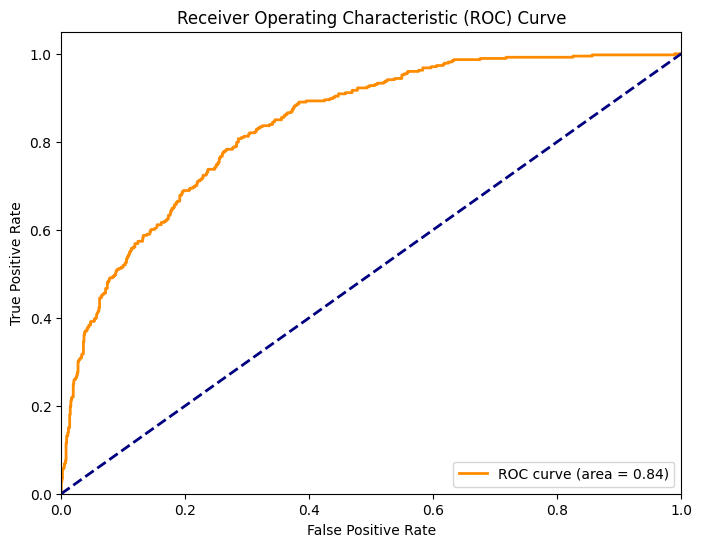

In [ ]:
#Model Evaluation

# ROC curve for XGBoost model
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

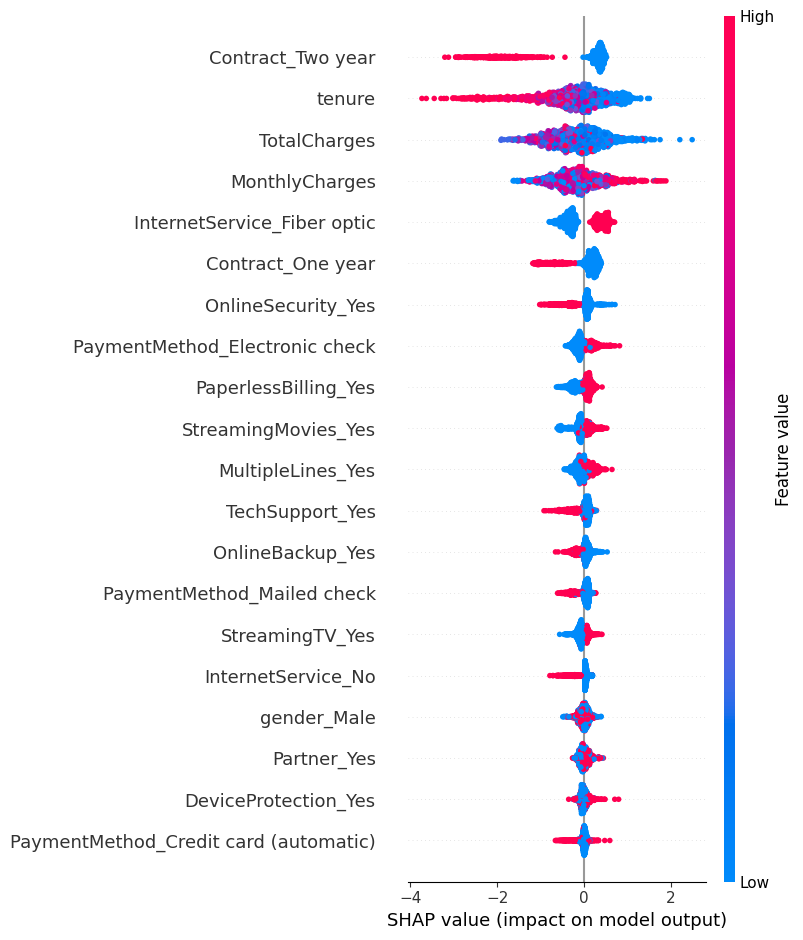

In [ ]:
#Model Interpretation

# SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_test)

# Summary plot
shap.summary_plot(shap_values, x_test)